# Socio-economic Factors and WFH rate

## Introduction
In this section, I used ACS data to explore nationwide WFH trend and socio-economic factors associate with it. Then, I leveraged conventional multi-OLS model and machine learning method Random Forest model to predict future WFH rate.

## Methodology
- Overview of WFH rate in the US
- Pre-select features: Based on my experience, I selected features that possibly associate with WFH rate.
- Outlier treatment and feature engineering: clean data, handle outliers and combine similar features such as occupation types.
- Feature selection: using correlation matrix to filter out features that are not highly correlate with WFH, and have high multicollinearity.
- Build, test and improve model: random forest model and multi OLS model
- Use model to predict future wfh rate

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
# load data
df = pd.read_csv('/Users/luchen/Documents/Esri/Project/results/demographic/census_tract/R13409459_SL140.csv', na_values='')

print("Data shape:", df.shape)
print(df.head())

Data shape: (85395, 1319)
     Geo_FIPS                                     Geo_QName Geo_FILEID  \
0  1001020100     Census Tract 201, Autauga County, Alabama      ACSSF   
1  1001020200     Census Tract 202, Autauga County, Alabama      ACSSF   
2  1001020300     Census Tract 203, Autauga County, Alabama      ACSSF   
3  1001020400     Census Tract 204, Autauga County, Alabama      ACSSF   
4  1001020501  Census Tract 205.01, Autauga County, Alabama      ACSSF   

  Geo_STUSAB  Geo_SUMLEV  Geo_GEOCOMP  Geo_LOGRECNO  Geo_US  Geo_REGION  \
0         al         140            0          1789     NaN         NaN   
1         al         140            0          1790     NaN         NaN   
2         al         140            0          1791     NaN         NaN   
3         al         140            0          1792     NaN         NaN   
4         al         140            0          1793     NaN         NaN   

   Geo_DIVISION  ...  SE_A08002B_003  SE_A08002B_004  SE_A08002B_005  \
0     

## Features Used in the Model
Target feature
- % Workers 16 Years and Over: Worked At Home


- Basic demographic: 
    - ~~Population~~
    - Population Density (Per Sq. Mile)
    - ~~sex~~
    - ~~age: % Total Population: 18 to 34 Years~~ 
    - race: % White

- Household info:             
    - ~~% household with child~~
    - ~~Average Household Size~~
    - % Households income $100,000 or More
             
- Education level: % Population 25 Years and Over: Bachelor's Degree or Better
             
- Occupations Types:
This classification is based on correlation matrix analysis, and feature engineered from 12 variables to following three in the model.
    - % Workers highly likely WFH, combination of following occupations:
        - Management, Business, and Financial Operations  Occupations
        - Healthcare Support Occupations
    - % Workers very likely WFH, combination of following occupations:
        - Professional and Related Occupations
    - % Workers highly unlikely WFH, combination of following occupations:
        - Transportation and Material Moving Occupations
        - Production Occupations
    - ~~% Workers very unlikely WFH, combination of following occupations:~~
        - ~~Construction, Extraction, and Maintenance  Occupations~~
    - ~~% Workers with other type of occupations~~
             
- Housing info:             
    - ~~% house units occupied by renters~~
    - ~~Vacancy rate~~
    - ~~% housing units have 2.01 or More Occupants Per Room~~
    - ~~% renting housing units have move-in renter 2019 or later~~
    - Median House Value for All Owner-Occupied Housing Units
    - ~~Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)~~

- Commuting Means:
    - ~~Average time Commute to Work (In Min)~~
    - % Housing Units by Vehicles Available - No Vehicle Available
             
- ~~% Population Move-in within the year~~

In [14]:
# filter variables for the model
df_filtered = df[['Geo_FIPS', 'Geo_STATE', 'Geo_COUNTY', 'Geo_QName', 'Geo_STUSAB',
             
             # population
             'SE_A00001_001', 'SE_A00002_002', 
             # A00001_001:     Population
             # A00002_002:     Population Density (Per Sq. Mile)
             
             # sex
             'PCT_SE_A02001_003',
             # A02001_003:      Female
             
             # age
             'PCT_SE_B01001_003', 
             # PCT_B01001_003: % Total Population: 18 to 34 Years 
             
             # race
             'PCT_SE_A03001_002', 
             # A03001_002:      White Alone
             
             ### household type and size
             'PCT_SE_A10007A_014', 'SE_A10003_001', 
             # 'SE_A10003B_001', 
             # A10007A_014:         Child:
             # A10003_001: Average Household Size
             
             # education level
             'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better
             
            #  # industry categories
            #  'SE_A17004_001', 'PCT_SE_A17004_002', 'PCT_SE_A17004_003', 'PCT_SE_A17004_004', 'PCT_SE_A17004_005', 'PCT_SE_A17004_006', 
            #  'PCT_SE_A17004_007', 'PCT_SE_A17004_008', 'PCT_SE_A17004_009', 'PCT_SE_A17004_010', 'PCT_SE_A17004_011', 'PCT_SE_A17004_012', 'PCT_SE_A17004_013', 'PCT_SE_A17004_014',
            #  # A17004_001:     Total Employed Civilian Population 16 Years and Over
            #     # PCT_A17004_002: % Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining
            #     # PCT_A17004_003: % Employed Civilian Population 16 Years and Over: Construction
            #     # PCT_A17004_004: % Employed Civilian Population 16 Years and Over: Manufacturing
            #     # PCT_A17004_005: % Employed Civilian Population 16 Years and Over: Wholesale Trade
            #     # PCT_A17004_006: % Employed Civilian Population 16 Years and Over: Retail Trade
            #     # PCT_A17004_007: % Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities
            #     # PCT_A17004_008: % Employed Civilian Population 16 Years and Over: Information
            #     # PCT_A17004_009: % Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing
            #     # PCT_A17004_010: % Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services
            #     # PCT_A17004_011: % Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance
            #     # PCT_A17004_012: % Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services
            #     # PCT_A17004_013: % Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration
            #     # PCT_A17004_014: % Employed Civilian Population 16 Years and Over: Public Administration
            
             # occupations
             'PCT_SE_B17008_002', 'PCT_SE_B17008_003', 'PCT_SE_B17008_004', 'PCT_SE_B17008_005', 'PCT_SE_B17008_006', 'PCT_SE_B17008_007',
             'PCT_SE_B17008_008', 'PCT_SE_B17008_009', 'PCT_SE_B17008_010', 'PCT_SE_B17008_011', 'PCT_SE_B17008_012', 'PCT_SE_B17008_013', 'PCT_SE_B17008_014',
                # PCT_B17008_002: % Employed Civilian Population 16 Years and Over: Management, Business, and Financial Operations  Occupations
                # PCT_B17008_003: % Employed Civilian Population 16 Years and Over: Professional and Related Occupations
                # PCT_B17008_004: % Employed Civilian Population 16 Years and Over: Healthcare Support Occupations
                # PCT_B17008_005: % Employed Civilian Population 16 Years and Over: Protective Service Occupations
                # PCT_B17008_006: % Employed Civilian Population 16 Years and Over: Food Preparation and Serving Related Occupations
                # PCT_B17008_007: % Employed Civilian Population 16 Years and Over: Building and Grounds Cleaning and Maintenance  Occupations
                # PCT_B17008_008: % Employed Civilian Population 16 Years and Over: Personal Care and Service Occupations
                # PCT_B17008_009: % Employed Civilian Population 16 Years and Over: Sales and Related Occupations
                # PCT_B17008_010: % Employed Civilian Population 16 Years and Over: Office and Administrative Support Occupations
                # PCT_B17008_011: % Employed Civilian Population 16 Years and Over: Farming, Fishing, and Forestry Occupations
                # PCT_B17008_012: % Employed Civilian Population 16 Years and Over: Construction, Extraction, and Maintenance  Occupations
                # PCT_B17008_013: % Employed Civilian Population 16 Years and Over: Production Occupations
                # PCT_B17008_014: % Employed Civilian Population 16 Years and Over: Transportation and Material Moving Occupations
             
             # household income
             'SE_B14001_001', 'PCT_SE_B14001_002', 'PCT_SE_B14001_003', 'PCT_SE_B14001_004', 'PCT_SE_B14001_005', 'PCT_SE_B14001_006',
                # B14001_001:     Households   
                #   PCT_B14001_002: % Households: Less than $25,000
                #   PCT_B14001_003: % Households: $25,000 to $49,999
                #   PCT_B14001_004: % Households: $50,000 to $74,999
                #   PCT_B14001_005: % Households: $75,000 to $99,999
                #   PCT_B14001_006: % Households: $100,000 or More
             
             # renter occupied rate
             'PCT_SE_A10060_003', 
             # A10060_003:      Renter Occupied
             
             # vacancy rate
             'PCT_SE_A10044_003', 
             # A10044_003:      Vacant
             
             # Housing Units by Number of Occupants Per Room
             'PCT_SE_A10028_006', 
             # A10028_006:      2.01 or More Occupants Per Room
             
             #'PCT_SE_A10063B_002',   
             # renting housing units and newly move-in renter 2019 or later
             
             # house value
             'SE_A10036_001',
             # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value
             
             # renting price
             'SE_A18003_001',
             # A18003_001:   Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)
    
             # WFH rate
             'PCT_SE_A09005_008',
             # A09005_001:     Workers 16 Years and Over:
             #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
             
             # commuting time
             'SE_A09003_001',
             # A09003_001:     Average Commute to Work (In Min)
             
             # Housing Units by Vehicles Available
             'PCT_SE_A10030_002',
             # A10030_002:      No Vehicle Available
             
             # moving population rate
             'PCT_SE_A08001_002'
             # 209. Residence 1 Year Ago in the United States
               #   Universe:  Population 1 year and Over in the United States
               #   Name:      A08001
               #   Variables:
               #      A08001_001:   Total:
               #      A08001_002:      Same House 1 Year Ago
               #      A08001_003:      Moved WithIn Same County
               #      A08001_004:      Moved From Different County WithIn Same State
               #      A08001_005:      Moved From Different State
               #      A08001_006:      Moved From Abroad

             ]]

print (df_filtered['SE_A00001_001'].min())
print (df_filtered['SE_A00001_001'].max())

df_filtered = df[df['Geo_STUSAB'] == 'ny']

#df_filtered.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/census_tract/acs_census_filtered.csv', index=False)

print("Data shape:", df_filtered.shape)
print(df_filtered.head())

0
38223
Data shape: (5411, 1319)
          Geo_FIPS                                   Geo_QName Geo_FILEID  \
49732  36001000100     Census Tract 1, Albany County, New York      ACSSF   
49733  36001000201  Census Tract 2.01, Albany County, New York      ACSSF   
49734  36001000202  Census Tract 2.02, Albany County, New York      ACSSF   
49735  36001000301  Census Tract 3.01, Albany County, New York      ACSSF   
49736  36001000302  Census Tract 3.02, Albany County, New York      ACSSF   

      Geo_STUSAB  Geo_SUMLEV  Geo_GEOCOMP  Geo_LOGRECNO  Geo_US  Geo_REGION  \
49732         ny         140            0          3507     NaN         NaN   
49733         ny         140            0          3508     NaN         NaN   
49734         ny         140            0          3509     NaN         NaN   
49735         ny         140            0          3510     NaN         NaN   
49736         ny         140            0          3511     NaN         NaN   

       Geo_DIVISION  ...  SE_

In [20]:
### Data Processing and Feature Engineering
### handle outliers
census = df_filtered[(df_filtered['SE_A00001_001'] >= 200)].copy()

# drop nan
census = census.dropna()

# combine occupations
census['PCT_+4_ocp'] = census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_004'] 
census['PCT_+2_ocp'] = census['PCT_SE_B17008_003']
census['PCT_+1_ocp'] = census['PCT_SE_B17008_011'] + census['PCT_SE_B17008_008']
census['PCT_-1_ocp'] = census['PCT_SE_B17008_007'] + census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_005'] + census['PCT_SE_B17008_004'] 
census['PCT_-2_ocp'] = census['PCT_SE_B17008_012']
census['PCT_-4_ocp'] = census['PCT_SE_B17008_014'] + census['PCT_SE_B17008_013']

# # moving rate
# census['moving_in'] = 1 - census['PCT_SE_A08001_002']
              
print("Data shape:", census.shape)
print(census['Geo_FIPS'].head())

Data shape: (0, 1325)
Series([], Name: Geo_FIPS, dtype: int64)


In [ ]:
##### Data for viz


In [5]:
# WFH rate per state
group_by_state = census.groupby(['Geo_STATE'])['PCT_SE_A09005_008'].mean().sort_values(ascending=False)
print (group_by_state)

# Convert the grouped data to a DataFrame
grouped_state_df = pd.DataFrame(group_by_state)

# Reset the index to make 'week' a regular column
grouped_state_df.reset_index(inplace=True)

# Save to CSV
grouped_state_df[['Geo_STATE', 'PCT_SE_A09005_008']].to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/census_tract/wfh_group_by_state_census.csv', index=False)
## TODO ##
# map of wfh

Series([], Name: PCT_SE_A09005_008, dtype: float64)


In [6]:
# WFH rate per county
group_by_county = census.groupby(['Geo_FIPS'])['PCT_SE_A09005_008'].mean().sort_values(ascending=False)
print (group_by_county)

# Convert the grouped data to a DataFrame
grouped_county_df = pd.DataFrame(group_by_county)

# Reset the index to make 'week' a regular column
grouped_county_df.reset_index(inplace=True)

# Save to CSV
grouped_county_df[['Geo_FIPS', 'PCT_SE_A09005_008']].to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/census_tract/wfh_group_by_county_census.csv', index=False)

## TODO ##
# map of wfh

Series([], Name: PCT_SE_A09005_008, dtype: float64)


In [19]:
# correlation modeling

# STEP 2 - Selected Features

corr = census[[
             # population
             #'SE_A00001_001', 
             #'SE_A00002_002', 
             # A00001_001:     Population
             # A00002_002:     Population Density (Per Sq. Mile)
             
             # sex
             #'PCT_SE_A02001_003',
             # A02001_003:      Female
             
             # age
             #'PCT_SE_B01001_003', 
             # PCT_B01001_003: % Total Population: 18 to 34 Years 
             
             # race
             'PCT_SE_A03001_002', 
             # A03001_002:      White Alone
             
             ### household type and size
             #'PCT_SE_A10007A_014', 
             #'SE_A10003_001', 
             # 'SE_A10003B_001', 
             # A10007A_014:         Child:
             # A10003_001: Average Household Size
             
             # education level
             'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better
             
             # occupations
            #  'PCT_SE_B17008_002', 
            #  'PCT_SE_B17008_003', 
            #  'PCT_SE_B17008_004', 
            #  'PCT_SE_B17008_005', 
            #  'PCT_SE_B17008_006', 
            #  'PCT_SE_B17008_007',
            #  'PCT_SE_B17008_008', 
            #  'PCT_SE_B17008_009', 
            #  'PCT_SE_B17008_010', 
            #  'PCT_SE_B17008_011', 
            #  'PCT_SE_B17008_012', 
            #  'PCT_SE_B17008_013', 
            #  'PCT_SE_B17008_014',
            #  #'PCT_ocp_003005', # combine
            #     # PCT_B17008_002: % Employed Civilian Population 16 Years and Over: Management, Business, and Financial Operations  Occupations
            #     # PCT_B17008_003: % Employed Civilian Population 16 Years and Over: Professional and Related Occupations
            #     # PCT_B17008_004: % Employed Civilian Population 16 Years and Over: Healthcare Support Occupations
            #     # PCT_B17008_005: % Employed Civilian Population 16 Years and Over: Protective Service Occupations
            #     # PCT_B17008_006: % Employed Civilian Population 16 Years and Over: Food Preparation and Serving Related Occupations
            #     # PCT_B17008_007: % Employed Civilian Population 16 Years and Over: Building and Grounds Cleaning and Maintenance  Occupations
            #     # PCT_B17008_008: % Employed Civilian Population 16 Years and Over: Personal Care and Service Occupations
            #     # PCT_B17008_009: % Employed Civilian Population 16 Years and Over: Sales and Related Occupations
            #     # PCT_B17008_010: % Employed Civilian Population 16 Years and Over: Office and Administrative Support Occupations
            #     # PCT_B17008_011: % Employed Civilian Population 16 Years and Over: Farming, Fishing, and Forestry Occupations
            #     # PCT_B17008_012: % Employed Civilian Population 16 Years and Over: Construction, Extraction, and Maintenance  Occupations
            #     # PCT_B17008_013: % Employed Civilian Population 16 Years and Over: Production Occupations
            #     # PCT_B17008_014: % Employed Civilian Population 16 Years and Over: Transportation and Material Moving Occupations

            'PCT_+4_ocp', 
            #'PCT_+2_ocp', 
            #'PCT_+1_ocp', 
            #'PCT_-1_ocp', 
            'PCT_-2_ocp', 
            'PCT_-4_ocp',
            
             # household income
             'PCT_SE_B14001_006',
                #   PCT_B14001_006: % Households: $100,000 or More
             
             # renter occupied rate
             #'PCT_SE_A10060_003', 
             # A10060_003:      Renter Occupied
             
             # vacancy rate
             #'PCT_SE_A10044_003', 
             # A10044_003:      Vacant
             
             # Housing Units by Number of Occupants Per Room
             #'PCT_SE_A10028_006', 
             # A10028_006:      2.01 or More Occupants Per Room
             
             #'PCT_SE_A10063B_002',   
             # renting housing units and newly move-in renter 2019 or later
             
             # house value
             #'SE_A10036_001',
             # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value
             
             # renting price
             #'SE_A18003_001',
             # A18003_001:   Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)
    
             # WFH rate
             'PCT_SE_A09005_008',
             # A09005_001:     Workers 16 Years and Over:
             #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
             
             # commuting time
             'SE_A09003_001',
             # A09003_001:     Average Commute to Work (In Min)
             
            #'PCT_likely_ocp', 'PCT_unlikely_ocp',
            
             # Housing Units by Vehicles Available
             #'PCT_SE_A10030_002',
             # A10030_002:      No Vehicle Available
             
             # moving population rate
             #'moving_in'
             #'PCT_SE_A08001_002'
             # 209. Residence 1 Year Ago in the United States
               #   Universe:  Population 1 year and Over in the United States
               #   Name:      A08001
               #   Variables:
               #      A08001_001:   Total:
               #      A08001_002:      Same House 1 Year Ago
               #      A08001_003:      Moved WithIn Same County
               #      A08001_004:      Moved From Different County WithIn Same State
               #      A08001_005:      Moved From Different State
               #      A08001_006:      Moved From Abroad

             ]]

print("Data shape:", corr.shape)
print(corr.head())

#corr.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/census_tract/filtered_acs_census.csv', index=False)


Data shape: (0, 8)
Empty DataFrame
Columns: [PCT_SE_A03001_002, PCT_SE_B12001_004, PCT_+4_ocp, PCT_-2_ocp, PCT_-4_ocp, PCT_SE_B14001_006, PCT_SE_A09005_008, SE_A09003_001]
Index: []


In [8]:
# # change factor
# corr['wfh_factors'] = corr['PCT_SE_A09005_008'].copy()

# # # Determine how many values you want to change
# # num_to_change = int(0.5 * len(corr['wfh_factors']))

# # # Randomly select indices of the dataframe
# # indices_to_change = np.random.choice(corr.index, num_to_change, replace=False)

# # # Generate random values between 0.47 and 1.5
# # random_multipliers = np.random.uniform(0.47, 1.5, size=num_to_change)

# # # Change the selected values in the dataframe
# # corr.loc[indices_to_change, 'wfh_factors'] *= random_multipliers


# # Determine how many values you want to change
# # Generate random multipliers between 0.94 and 1.05
# random_multipliers = np.random.uniform(0.94, 1.05, size=len(corr['PCT_SE_A09005_008']))

# # Change the values in the column
# corr['wfh_factors'] *= random_multipliers

# num_to_change_1 = int(0.3 * len(corr['wfh_factors']))
# num_to_change_2 = int(0.09 * len(corr['wfh_factors']))
# num_to_change_3 = int(0.07 * len(corr['wfh_factors']))

# # Randomly select indices of the dataframe for each change group
# indices_to_change_1 = np.random.choice(corr.index, num_to_change_1, replace=False)
# indices_to_change_2 = np.random.choice(list(set(corr.index) - set(indices_to_change_1)), num_to_change_2, replace=False)
# indices_to_change_3 = np.random.choice(list(set(corr.index) - set(indices_to_change_1) - set(indices_to_change_2)), num_to_change_3, replace=False)

# # Generate random values within each specific range
# random_multipliers_1 = np.random.uniform(0.47, 1.5, size=num_to_change_1)
# random_multipliers_2 = np.random.uniform(1.0, 3.0, size=num_to_change_2)
# random_multipliers_3 = np.random.uniform(0.05, 1.0, size=num_to_change_3)

# # Change the selected values in the dataframe
# corr.loc[indices_to_change_1, 'wfh_factors'] *= random_multipliers_1
# corr.loc[indices_to_change_2, 'wfh_factors'] *= random_multipliers_2
# corr.loc[indices_to_change_3, 'wfh_factors'] *= random_multipliers_3

PCT_SE_A03001_002   NaN
PCT_SE_B12001_004   NaN
PCT_+4_ocp          NaN
PCT_-2_ocp          NaN
PCT_-4_ocp          NaN
PCT_SE_B14001_006   NaN
PCT_SE_A09005_008   NaN
SE_A09003_001       NaN
Name: PCT_SE_A09005_008, dtype: float64


/Users/luchen/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/luchen/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


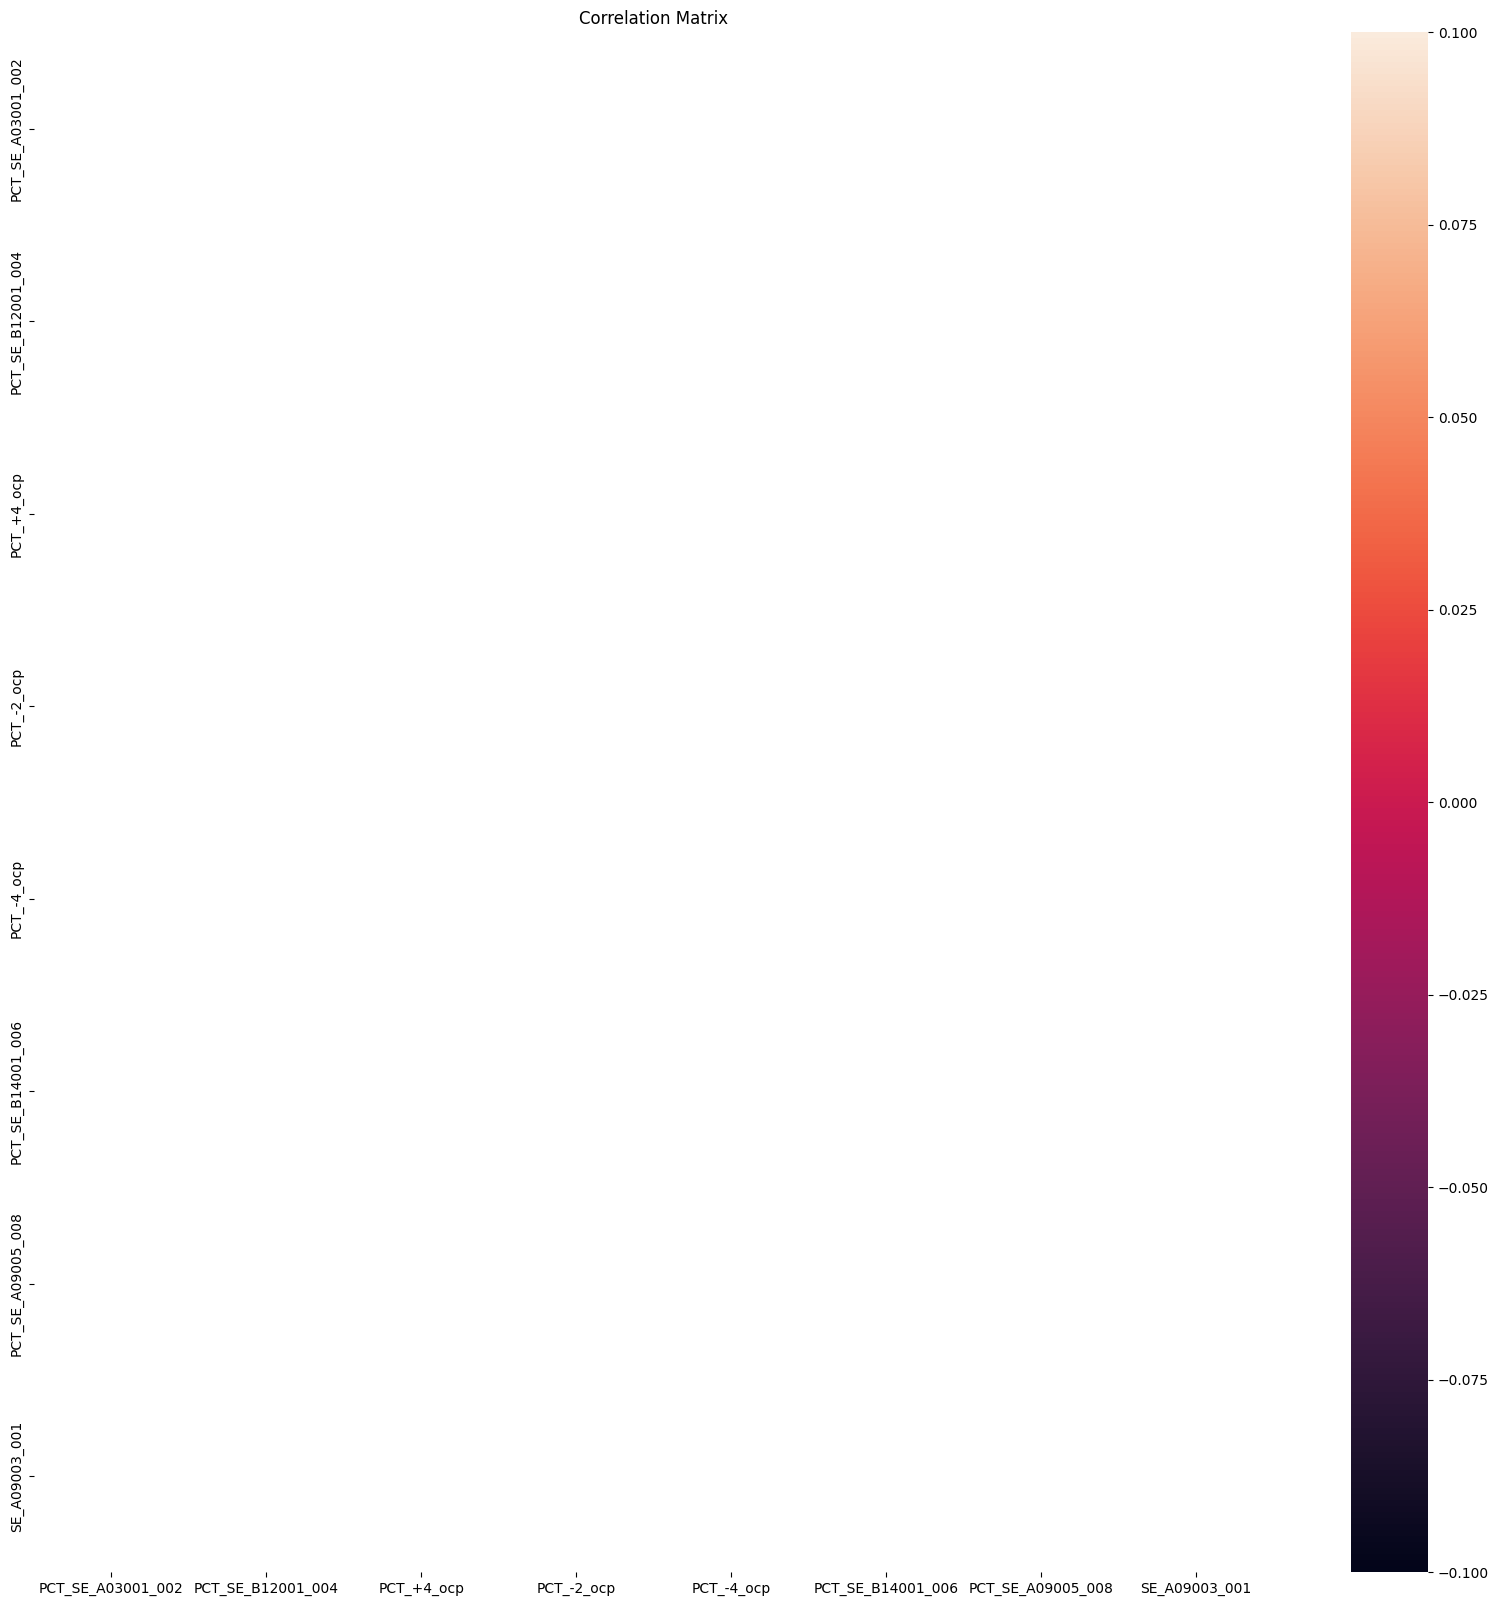

In [18]:

# create a correlation matrix
corr_matrix = corr.corr()
print(corr_matrix['PCT_SE_A09005_008'].sort_values(ascending=False))


# plot a heatmap to visualize the correlations
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

corr_matrix = corr_matrix['PCT_SE_A09005_008']


In [10]:
# ## Clean up df
# corr_viz = census[[
#              # population
#              #'SE_A00001_001', 
#              'SE_A00002_002', 
#              # A00001_001:     Population
#              # A00002_002:     Population Density (Per Sq. Mile)
             
#              # race
#              'PCT_SE_A03001_002', 
#              # A03001_002:      White Alone
             
#              # education level
#              'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better

#             'PCT_+4_ocp', 
#             'PCT_+2_ocp', 
#             # 'PCT_+1_ocp', 
#             # 'PCT_-1_ocp', 
#             #'PCT_-2_ocp', 
#             'PCT_-4_ocp',
            
#              # household income
#              'PCT_SE_B14001_006',
#                 #   PCT_B14001_006: % Households: $100,000 or More
             
#              # house value
#              'SE_A10036_001',
#              # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value

#              # WFH rate
#              'PCT_SE_A09005_008',
#              # A09005_001:     Workers 16 Years and Over:
#              #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
            
#              # Housing Units by Vehicles Available
#              'PCT_SE_A10030_002',
#              # A10030_002:      No Vehicle Available

#              ]].copy()

# column_name_map = {
#                     'SE_A00002_002': 'Population Density',
#                     'PCT_SE_A03001_002': '% White population',
#                     'PCT_SE_B12001_004': ' % Bachelor or higher',
#                     'PCT_+4_ocp': '% Occupations - Highly likely WFH',
#                     'PCT_+2_ocp': '% Occupations - Very likely WFH',
#                     'PCT_-4_ocp': '% Occupations - Highly unlikely WFH',
#                     'PCT_SE_B14001_006': '% Households income $100,000 or More',
#                     'SE_A10036_001': 'Median House Value',
#                     'PCT_SE_A10030_002': '% No Vehicle household',
#                     'PCT_SE_A09005_008': 'WFH rate'
#                     }

# # Rename the columns using the dictionary
# corr_viz.rename(columns=column_name_map, inplace=True)

# corr_viz.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/modeling_wfh.csv', index=False)


In [11]:
# We'll use linear regression to try to predict 'PCT_SE_A09005_008'
# First, drop the non-numerical columns
numerical_df = corr.select_dtypes(include=[np.number])
numerical_df = numerical_df.dropna(axis=1)  # drop any columns with missing data

# prepare the data for the model
X = numerical_df.drop(['PCT_SE_A09005_008'], axis=1)  # feature columns
y = numerical_df['PCT_SE_A09005_008']  # target column

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# print model accuracy
print("Model Accuracy: ", model.score(X_test, y_test))

# print root mean squared error of the model
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
#### correlations with 'PCT_SE_A09005_008' > 0.1
# Use boolean indexing to filter out rows with absolute correlation less than threshold
corr_matrix_01 = corr_matrix[corr_matrix.abs() > 0.1].dropna()

# Now 'filtered_corr_matrix' is your filtered correlation matrix
print(corr_matrix_01.sort_values(ascending=False))

# PCT_SE_A09005_008     1.000000 
# PCT_SE_B17008_002     0.670137 job - Management, Business, and Financial Operations  Occupations
# PCT_SE_B12001_004     0.570593 bachelor and higher education
# SE_A10036_001         0.522578 house Median Value
# PCT_SE_B14001_006     0.496803 Households income: $100,000 or More
# PCT_SE_B17008_003     0.310810 job - Professional and Related Occupations
# SE_A00001_001         0.209459 Total Population
#### PCT_SE_A10028_002     0.157873 Occupied Housing Units: 0.50 or Less Occupants Per Room
# PCT_SE_A03001_002     0.148828 White Alone rate
# SE_A00002_002         0.130798 Population Density (Per Sq. Mile)
# PCT_SE_B17008_008     0.122832 job - Personal Care and Service Occupations
# SE_A10003_001        -0.102801 Average Household Size
# PCT_SE_B17008_004    -0.132468 job - Healthcare Support Occupations
# PCT_SE_B17008_007    -0.133276 job - Building and Grounds Cleaning and Maintenance  Occupations
# PCT_SE_A10030_002    -0.141094 Occupied Housing Units: No Vehicle Available
# PCT_SE_A10007A_014   -0.154723 Child
# PCT_SE_B17008_005    -0.171769 job - Protective Service Occupations
# PCT_SE_B17008_012    -0.230769 job - Construction, Extraction, and Maintenance  Occupations
# PCT_SE_B17008_014    -0.415333 job - Transportation and Material Moving Occupations
# PCT_SE_B17008_013    -0.437578 job - Production Occupations

# filter origional df, only keep above variables
cols_to_keep = corr_matrix_01.index.str.split().str[0]
corr_01 = corr[cols_to_keep]

# column_name_map = {
#                     'SE_A00002_002': 'Population Density',
#                     'PCT_SE_A03001_002': '% White population',
#                     'PCT_SE_B12001_004': ' % Bachelor or higher',
#                     'PCT_+4_ocp': '% Occupations - Highly likely WFH',
#                     'PCT_+2_ocp': '% Occupations - Very likely WFH',
#                     'PCT_-4_ocp': '% Occupations - Highly unlikely WFH',
#                     'PCT_SE_B14001_006': '% Households income $100,000 or More',
#                     'SE_A10036_001': 'Median House Value',
#                     'PCT_SE_A10030_002': '% No Vehicle household',
#                     'PCT_SE_A09005_008': 'WFH rate'
#                     }

# # Rename the columns using the dictionary
# corr_01 .rename(columns=column_name_map, inplace=True)

corr_01.head()

PCT_SE_A09005_008    1.000000
wfh_factors          0.843159
PCT_SE_B12001_004    0.655851
PCT_SE_B14001_006    0.555192
PCT_+4_ocp           0.530831
PCT_SE_A03001_002    0.123517
SE_A09003_001        0.110289
PCT_-2_ocp          -0.359649
PCT_-4_ocp          -0.498618
Name: PCT_SE_A09005_008, dtype: float64


,PCT_SE_A03001_002,PCT_SE_B12001_004,PCT_+4_ocp,PCT_-2_ocp,PCT_-4_ocp,PCT_SE_B14001_006,PCT_SE_A09005_008,SE_A09003_001,wfh_factors
0,83.86,21.96,17.79,9.84,12.40,24.47,1.24,19.0,0.894351
1,39.05,19.32,32.11,4.53,16.56,21.00,6.60,26.0,9.187592
2,68.02,16.15,21.98,10.27,18.57,19.99,2.50,22.0,5.989055
3,89.69,35.86,16.95,7.78,24.22,33.69,5.64,24.0,5.876360
4,75.85,38.53,19.72,4.03,10.06,24.43,4.21,21.0,11.492810


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set 
X = corr_01  # fill this with the names of your features

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data.sort_values(by='VIF'))

### New variables
#                feature         VIF
# 0        SE_A00001_001    1.479032
# 1        SE_A00002_002    1.756214
# 9    PCT_SE_B17008_005    4.463159
# 19   PCT_SE_A10030_002    5.623752
# 11   PCT_SE_B17008_008    6.981120
# 8    PCT_SE_B17008_004    7.251015
# 13   PCT_SE_B17008_013    9.312683
# 18   PCT_SE_A09005_008    9.433707
# 10   PCT_SE_B17008_007   10.261999
# 17       SE_A10036_001   13.065851
# 14   PCT_SE_B17008_014   18.448536
# 12   PCT_SE_B17008_012   18.750001
# 15   PCT_SE_B14001_006   25.406699
# 6    PCT_SE_B17008_002   35.256899
# 2    PCT_SE_A03001_002   37.401615 white
# 5    PCT_SE_B12001_004   37.854384 Bachelor's Degree or Better
# 7    PCT_SE_B17008_003   55.569799 Professional and Related Occupations
# 3   PCT_SE_A10007A_014  121.987911 child
#### x 16   PCT_SE_A10028_002  166.248418 0.50 or Less Occupants Per Room
# 4        SE_A10003_001  245.544362 Average Household Size   

             feature        VIF
4         PCT_-4_ocp   4.417614
3         PCT_-2_ocp   4.459806
8        wfh_factors   7.755107
0  PCT_SE_A03001_002   8.616958
5  PCT_SE_B14001_006  10.509226
6  PCT_SE_A09005_008  11.801360
2         PCT_+4_ocp  11.883252
1  PCT_SE_B12001_004  12.728410
7      SE_A09003_001  13.288006


In [ ]:
# # We'll use linear regression to try to predict 'PCT_SE_A09005_008'
# First, drop the non-numerical columns
numerical_df = corr_01.select_dtypes(include=[np.number])
numerical_df = numerical_df.dropna(axis=1)  # drop any columns with missing data

# prepare the data for the model
X = numerical_df.drop(['PCT_SE_A09005_008'], axis=1)  # feature columns
y = numerical_df['PCT_SE_A09005_008']  # target column

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# print model accuracy
print("R_sqr: ", model.score(X_test, y_test))

# print root mean squared error of the model
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Model Accuracy:  0.5447290108359033
# Root Mean Squared Error:  2.510557765700817

### 0.1
# Model Accuracy:  0.5642617743409818
# Root Mean Squared Error:  2.4561113969779975

### new variable with all occupations
# Model Accuracy:  0.54552781805636
# Root Mean Squared Error:  2.641763214035176

R_sqr:  0.7694453165026423
Root Mean Squared Error:  3.3210028942068304


In [ ]:
# Random Forest Prediction

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets[[']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Use the model to predict the test set results
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate Model Accuracy
r_sqr = rf.score(X_test, y_test)

print(f'R square: {r_sqr}')
print(f'Root Mean Squared Error: {rmse}')

# Model Accuracy: 0.5629331712186789
# Root Mean Squared Error: 2.4598529939068827

### 0.1
# Model Accuracy: 0.5704371756265633
# Root Mean Squared Error: 2.438644950165364

### new variable with all occupations
# Model Accuracy: 0.5891962418595987
# Root Mean Squared Error: 2.511640282113597

R square: 0.8159982044029064
Root Mean Squared Error: 2.9668344289375805


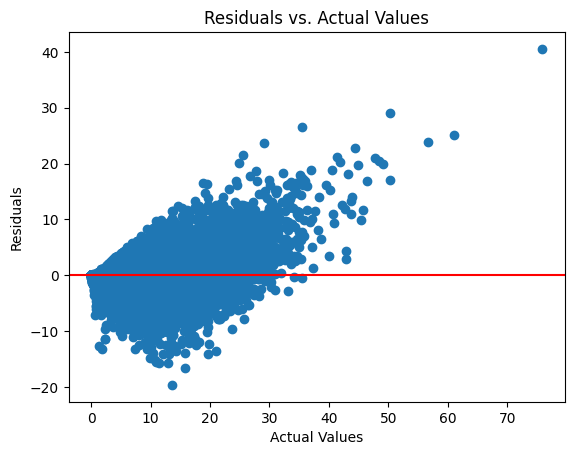

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Create a scatter plot of the residuals
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') # This line indicates where residuals would be 0
plt.title('Residuals vs. Actual Values')
plt.show()

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# # Initialize the model
# rf = RandomForestRegressor(random_state=42)

# # Initialize the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# # Train and predict using the model with the best parameters
# rf_best = RandomForestRegressor(**best_params, random_state=42)
# rf_best.fit(X_train, y_train)
# y_pred = rf_best.predict(X_test)

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# # Calculate Model Accuracy
# r_sqr = rf_best.score(X_test, y_test)

# print(f'Best Parameters: {best_params}')
# print(f'R square: {r_sqr}')
# print(f'Root Mean Squared Error: {rmse}')

# Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
# R square: 0.5957757738307609
# Root Mean Squared Error: 2.491445576945272


In [ ]:
# ### Best Random Forest

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the model with the best parameters
# rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_depth=None, random_state=42)

# # Fit the model on the training data
# rf.fit(X_train, y_train)

# # Use the model to predict the test set results
# y_pred = rf.predict(X_test)

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# # Calculate Model Accuracy
# r_sqr = rf.score(X_test, y_test)

# print(f'R square: {r_sqr}')
# print(f'Root Mean Squared Error: {rmse}')

In [ ]:
## Multi-OLS

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# predictor variables are stored in X and your target variable in y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the independent value
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Conduct the multiple linear regression
model = sm.OLS(y_train, X_train).fit()

# Print the summary statistics of the regression model
print(model.summary())

# Predict the test set results
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r_sqr = model.rsquared

print(f'R square: {r_sqr}')
print(f'Root Mean Squared Error: {rmse}')


                            OLS Regression Results                            
Dep. Variable:      PCT_SE_A09005_008   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                 2.606e+04
Date:                Thu, 06 Jul 2023   Prob (F-statistic):               0.00
Time:                        23:44:30   Log-Likelihood:            -1.6465e+05
No. Observations:               62802   AIC:                         3.293e+05
Df Residuals:                   62793   BIC:                         3.294e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3470      0.10

OLS Regression Results                            
==============================================================================
Dep. Variable:      PCT_SE_A09005_008   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     7874.
Date:                Thu, 06 Jul 2023   Prob (F-statistic):               0.00
Time:                        23:00:33   Log-Likelihood:            -1.9081e+05
No. Observations:               62802   AIC:                         3.816e+05
Df Residuals:                   62794   BIC:                         3.817e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3872      0.155     -2.498      0.012      -0.691      -0.083
PCT_SE_A03001_002     0.0052      0.001      5.979      0.000       0.003       0.007
PCT_SE_B12001_004     0.1562      0.002     76.315      0.000       0.152       0.160
PCT_+4_ocp            0.1407      0.004     39.518      0.000       0.134       0.148
PCT_-2_ocp           -0.0251      0.005     -5.558      0.000      -0.034      -0.016
PCT_-4_ocp           -0.0564      0.003    -16.740      0.000      -0.063      -0.050
PCT_SE_B14001_006     0.0290      0.002     16.167      0.000       0.026       0.033
SE_A09003_001         0.0569      0.003     18.372      0.000       0.051       0.063
==============================================================================
Omnibus:                    13657.833   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43593.486
Skew:                           1.108   Prob(JB):                         0.00
Kurtosis:                       6.427   Cond. No.                         719.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
R square: 0.4674609594412471

In [ ]:
# ### HOW TO USE THE RANDOM FOREST MODEL
# # Assuming that 'future_data' is your new data for which you want to predict WFH rates.
# # 'future_data' should be a DataFrame that includes all the necessary features 
# # and is preprocessed in the same way as your training and test data.

# # Make sure that the new data has the same features as the data the model was trained on.
# assert set(future_data.columns) == set(X.columns), "Features do not match!"

# future_predictions = rf.predict(future_data)

# # Now, 'future_predictions' contains the predicted WFH rates for your future data.
# print(future_predictions)

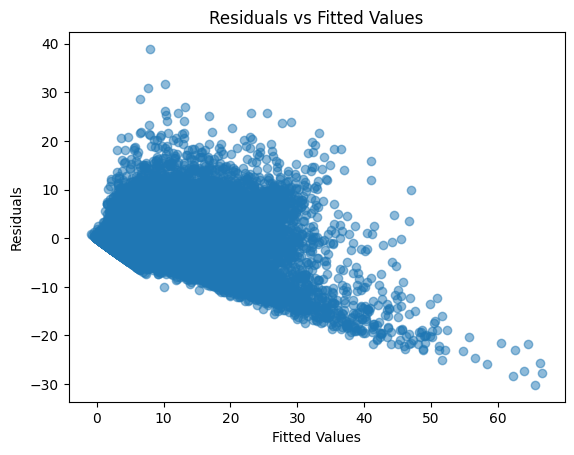

In [ ]:
# Predicted values
fitted_values = model.predict()

# Residuals
residuals = model.resid

plt.scatter(fitted_values, residuals, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

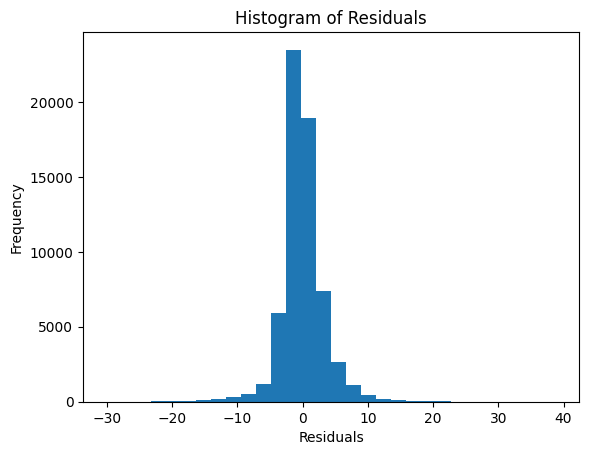

In [ ]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()